## 1. Loading and Previewing the Data 

First thing's first, let's load up the data and get a quick feel for it (reminder that the dataset is available [here](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)). 

Note that there are a good number of NaN values in the data that don't disambiguate missing from zero. For the sake of simplicity in this tutorial, we'll naively fill these with 0 later on.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from google.colab import drive
drive.mount("/content/gdrive")

df = pd.read_csv('/content/gdrive/MyDrive/solar_irradiation_data.csv')
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Time,Timezone,GHI_AVG,DNI_AVG,WDIR_AVG,WSPD_AVG,TEMP_AVG,HUM_AVG,RAIN_SUM
0,2019-07-01 00:00:00,ACST,-1.251141,-1.681195,226.046751,0.270745,4.599429,49.373845,0.0
1,2019-07-01 01:00:00,ACST,-1.105491,-1.564169,231.856001,0.438133,3.880017,50.883139,0.0
2,2019-07-01 02:00:00,ACST,-1.110939,-1.588327,235.262640,0.391107,3.119183,53.990385,0.0
3,2019-07-01 03:00:00,ACST,-0.995637,-1.483157,246.829333,0.444790,3.146530,54.673470,0.0
4,2019-07-01 04:00:00,ACST,-1.001849,-1.464027,249.490834,0.454146,5.106388,48.845702,0.0


In [ ]:
# ONLY RUN WHEN THE DATASET IS BEING USED DIRECTLY
df1 = df.copy()
df1['TIME'] = pd.to_datetime(df1['Time'])
df1['hour'] = df1['TIME'].dt.hour

df1.drop(['Timezone'], axis = 1, inplace = True)
df1.drop(['RAIN_SUM'], axis = 1, inplace = True)
df1.drop(['TIME'],axis =1, inplace = True)

df1 = df1.dropna(subset = ['GHI_AVG'])

# About the Nan and -ve values, cause it creates an issue
df1.loc[(df1['GHI_AVG'] < 0) | (df1['DNI_AVG'] < 0) | (df1['WDIR_AVG']<0) | (df1['WSPD_AVG']<0) | (df1['TEMP_AVG']<0) | (df1['HUM_AVG']<0), ['GHI_AVG', 'DNI_AVG', 'WDIR_AVG', 'WSPD_AVG','TEMP_AVG', 'HUM_AVG', 'RAIN_SUM']] = 0

df1

,Time,GHI_AVG,DNI_AVG,WDIR_AVG,WSPD_AVG,TEMP_AVG,HUM_AVG,hour,RAIN_SUM
0,2019-07-01 00:00:00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.0
1,2019-07-01 01:00:00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,0.0
2,2019-07-01 02:00:00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2,0.0
3,2019-07-01 03:00:00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3,0.0
4,2019-07-01 04:00:00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4,0.0
...,...,...,...,...,...,...,...,...,...
27809,2022-09-01 17:00:00,28.101389,0.0,145.524306,1.942893,12.795519,95.269921,17,NaN
27810,2022-09-01 18:00:00,0.883333,0.0,136.775139,1.787685,12.445601,98.542388,18,NaN
27811,2022-09-01 19:00:00,0.000000,0.0,135.269583,2.099801,11.979293,99.854972,19,NaN
27812,2022-09-01 20:00:00,0.000000,0.0,129.577778,0.919404,11.599545,99.721071,20,NaN


In [ ]:
df1.describe()

,GHI_AVG,DNI_AVG,WDIR_AVG,WSPD_AVG,TEMP_AVG,HUM_AVG,hour,RAIN_SUM
count,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000,8083.0
mean,260.080333,306.016622,109.525318,1.094615,15.572162,25.284537,11.518613,0.0
std,351.265701,398.354978,96.060695,1.302488,13.039717,24.949310,6.918370,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.0
50%,0.819444,0.000000,116.575126,0.525600,16.907557,21.071548,12.000000,0.0
75%,548.069702,767.101214,178.500056,2.047388,26.535926,39.142933,18.000000,0.0
max,1170.911090,1076.749711,325.554167,58.192218,44.854888,99.932081,23.000000,0.0


In [ ]:
dft = df1.set_index('Time').T.reset_index(drop=False)
dft

Time,index,2019-07-01 00:00:00,2019-07-01 01:00:00,2019-07-01 02:00:00,2019-07-01 03:00:00,2019-07-01 04:00:00,2019-07-01 05:00:00,2019-07-01 06:00:00,2019-07-01 07:00:00,2019-07-01 08:00:00,...,2022-09-01 12:00:00,2022-09-01 13:00:00,2022-09-01 14:00:00,2022-09-01 15:00:00,2022-09-01 16:00:00,2022-09-01 17:00:00,2022-09-01 18:00:00,2022-09-01 19:00:00,2022-09-01 20:00:00,2022-09-01 21:00:00
0,GHI_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.691893,205.014492,...,171.306944,146.815278,397.580556,120.298611,99.322222,28.101389,0.883333,0.000000,0.000000,0.000000
1,DNI_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.923585,702.892465,...,0.000000,0.000000,42.477778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,WDIR_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173.649389,194.149584,...,107.092917,106.599028,98.092639,143.875417,141.260417,145.524306,136.775139,135.269583,129.577778,145.930000
3,WSPD_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.563628,1.109589,...,1.056710,1.626819,2.646124,1.976757,1.864640,1.942893,1.787685,2.099801,0.919404,0.739417
4,TEMP_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.970904,13.686888,...,10.964323,11.592841,12.566402,12.903492,12.915450,12.795519,12.445601,11.979293,11.599545,11.415985
5,HUM_AVG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.616153,28.857826,...,99.881789,99.856209,98.669837,96.680905,95.157149,95.269921,98.542388,99.854972,99.721071,99.879030
6,hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.000000,8.000000,...,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,21.000000
7,RAIN_SUM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Columns: 25843 entries, index to 2022-09-01 21:00:00
dtypes: float64(25842), object(1)
memory usage: 1.6+ MB


In [ ]:
data_start_date = dft.columns[1]
data_end_date = dft.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2019-07-01 00:00:00 to 2022-09-01 21:00:00


We can define a function that lets us visualize some random webpage series as below. For the sake of smoothing out the scale of traffic across different series, we apply a log1p transformation before plotting - i.e. take $\log(1+x)$ for each value $x$ in a series.

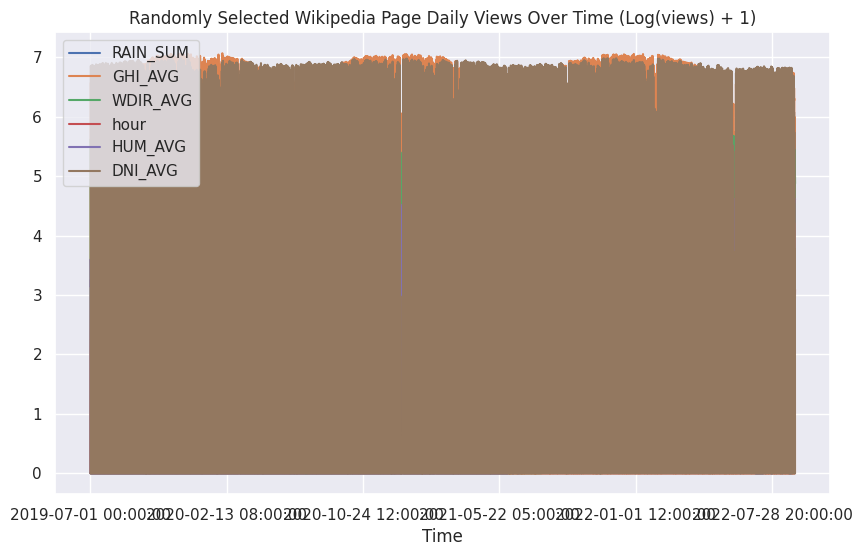

In [ ]:
def plot_random_series(df, n_series):
    
    sample = dft.sample(n_series, random_state=8)
    page_labels = sample['index'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

## 2. Formatting the Data for Modeling 


In [ ]:
from datetime import timedelta

pred_steps = 24*7  #
pred_length=timedelta(hours = pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(hours = 1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(hours = 1) 

In [ ]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(hours = 1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(hours = 1) 

In [ ]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2019-07-01 00:00:00 - 2022-08-18 21:00:00
Train prediction: 2022-08-18 22:00:00 - 2022-08-25 21:00:00 

Val encoding: 2019-07-08 00:00:00 - 2022-08-25 21:00:00
Val prediction: 2022-08-25 22:00:00 - 2022-09-01 21:00:00

Encoding interval: 1144
Prediction interval: 7


### Keras Data Formatting

Now that we have the time segment dates, we'll define the functions we need to extract the data in keras friendly format. Here are the steps:

* Pull the time series into an array, save a date_to_index mapping as a utility for referencing into the array 
* Create function to extract specified time interval from all the series 
* Create functions to transform all the series. 
    - Here we smooth out the scale by taking log1p and de-meaning each series using the encoder series mean, then reshape to the **(n_series, n_timesteps, n_features) tensor format** that keras will expect. 
    - Note that if we want to generate true predictions instead of log scale ones, we can easily apply a reverse transformation at prediction time. 

In [ ]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in dft.columns[1:]]),
                          data=[i for i in range(len(dft.columns[1:]))])

series_array = dft[dft.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [ ]:
series_array

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 135.26958333,
        129.57777778, 145.93      ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  99.85497208,
         99.72107097,  99.87903   ],
       [  0.        ,   1.        ,   2.        , ...,  19.        ,
         20.        ,  21.        ],
       [  0.        ,   0.        ,   0.        , ...,          nan,
                 nan,          nan]])

## 3. Building the Model - Architecture
### **Our Architecture**

Here's what we'll use:

* 8 dilated causal convolutional layers
    * 32 filters of width 2 per layer
    * Exponentially increasing dilation rate (1, 2, 4, 8, ..., 128) 
* 2 (time distributed) fully connected layers to map to final output 

We'll extract the last 14 steps from the output sequence as our predicted output for training. We'll use teacher forcing again during training. Similarly to the previous notebook, we'll have a separate function that runs an inference loop to generate predictions on unseen data, iteratively filling previous predictions into the history sequence (section 4).

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':168})(x)

model = Model(history_seq, pred_seq_train)

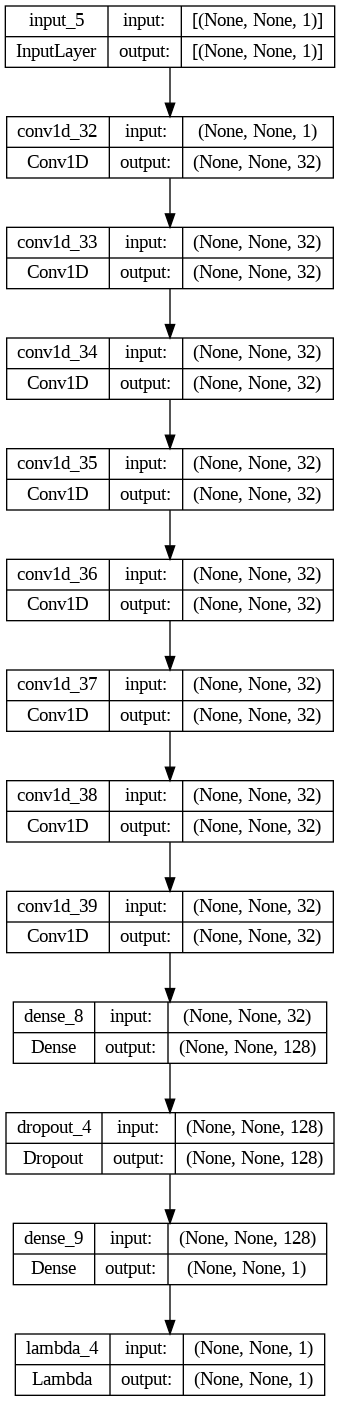

In [ ]:
from keras.utils.vis_utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model.png', show_shapes=True)


In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d_32 (Conv1D)          (None, None, 32)          96        
                                                                 
 conv1d_33 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_34 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_35 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_36 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_37 (Conv1D)          (None, None, 32)          2080



For better results, you could try using more data, adjusting the hyperparameters, tuning the learning rate and number of epochs, etc.  

In [ ]:
first_n_samples = 7 
batch_size = 2**7
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=10,
                    validation_split=0.2)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.8744 - val_loss: 0.9475
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 1.6895 - val_loss: 0.8512
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 1.5076 - val_loss: 0.7405
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1.2864 - val_loss: 0.6149
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 1.0285 - val_loss: 0.4899
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.7732 - val_loss: 0.3932
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.7043 - val_loss: 0.4402
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.8218 - val_loss: 0.4463
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.8154 - val_loss: 0.4108
Epoch 10/10
1/1 [==============================] - 1s 1s/step - loss: 0.7347 - val_loss: 0.4140


It's typically a good idea to look at the convergence curve of train/validation loss.

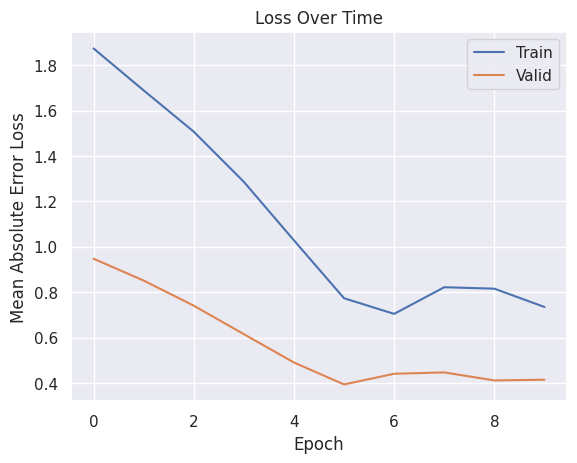

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

## 4. Building the Model - Inference Loop


In [ ]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

## 5. Generating and Plotting Predictions 


In [ ]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [ ]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

Generating some plots as below, we can see that our predictions look better than in the previous notebook. They can effectively anticipate many patterns in the data (e.g. behavior across different week days) and capture some trends nicely. They are definitely more sensitive to the variability in the data than the overly conservative LSTM predictions from the previous notebook. 

Still, we would likely stand to gain even more from increasing the sample size for training and expanding on the network architecture/hyperparameter tuning.  

**Check out the next notebook in this series** for further exploration of the WaveNet architecture, including fancier components like gated activations and skip connections. If you're interested in digging even deeper into state of the art WaveNet style architectures, I also highly recommend checking out [Sean Vasquez's model](https://github.com/sjvasquez/web-traffic-forecasting) that was designed for this data set. He implements a customized seq2seq WaveNet architecture in tensorflow.    

1/1 [==============================] - 0s 86ms/step


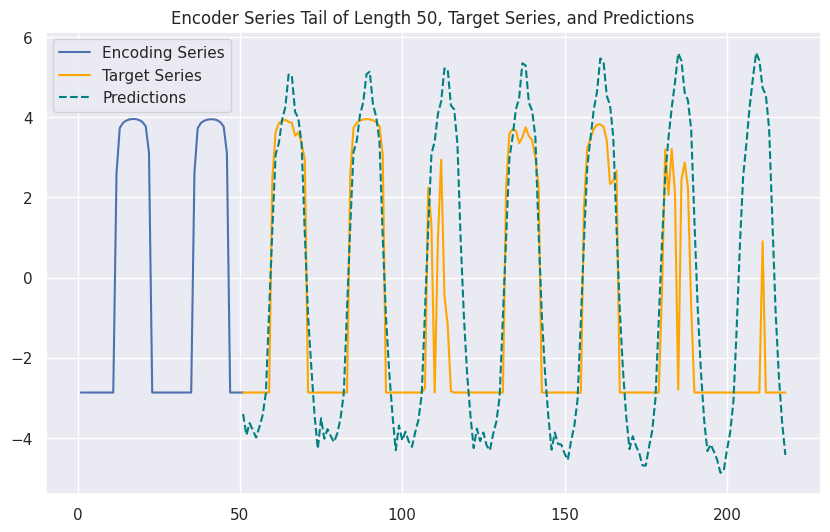

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 1)

1/1 [==============================] - 0s 121ms/step


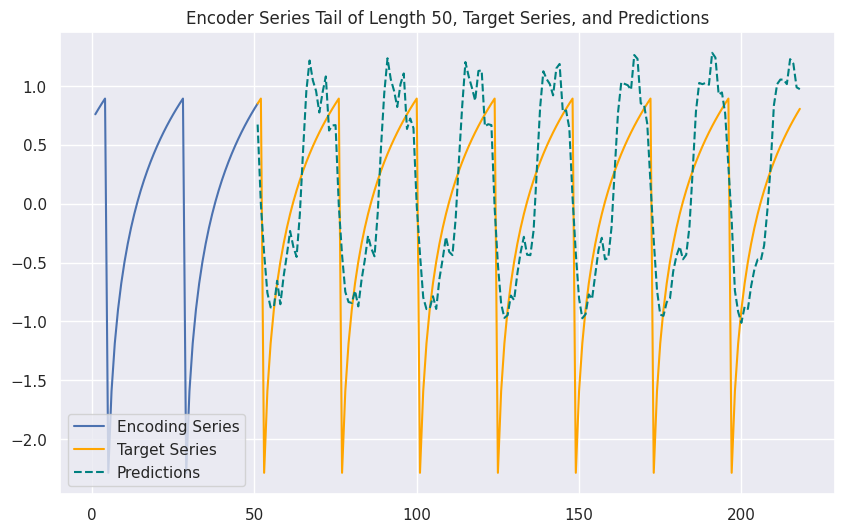

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 6)

1/1 [==============================] - 0s 72ms/step


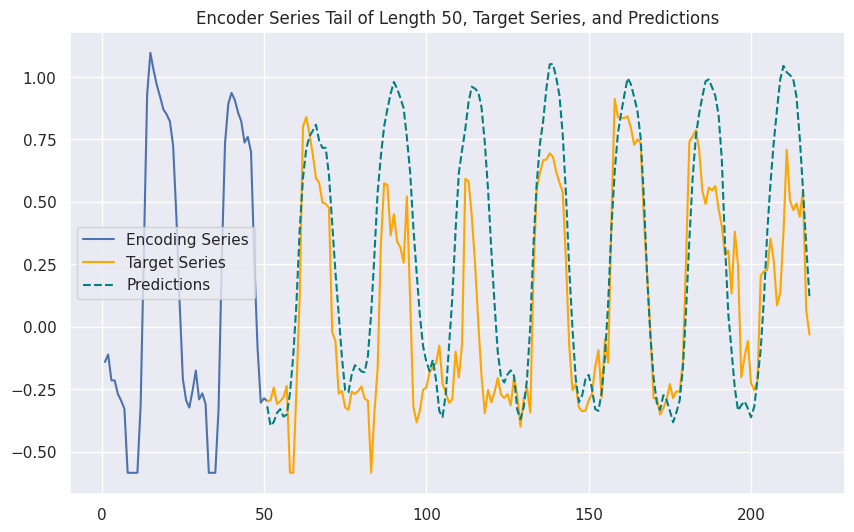

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 3)

1/1 [==============================] - 0s 77ms/step


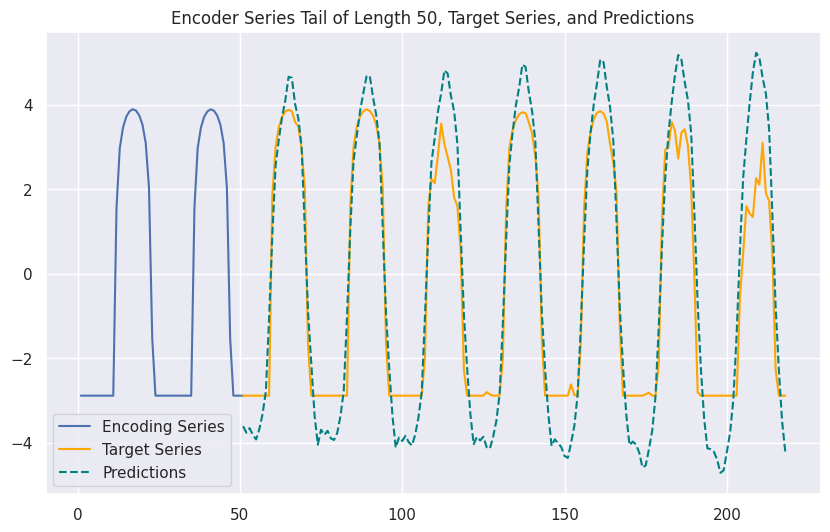

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 0)

1/1 [==============================] - 0s 77ms/step


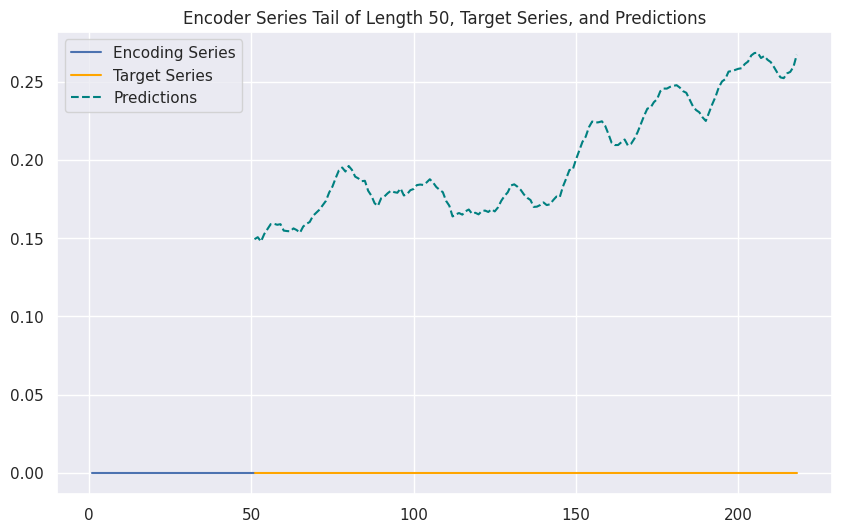

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 7)

This last prediction example is interesting - the model clearly understands the recurring pattern in the series well, but struggles to properly capture the downward trend that's in place.